In [1]:
# Import Required Libraries
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

<h2>Step 1: Data Preparation</h2>

In [2]:
df = pd.read_csv("test.log",sep='|',parse_dates=True,
                 header=None,names=['datetime','user','log','process'])

In [3]:
df.head()

,datetime,user,log,process
0,2021-01-01 08:20:00,MKSEK,Starting process,Process A
1,2021-01-01 09:10:00,MKSEK,Completed process successfully,Process A
2,2021-02-01 08:20:00,MKSEK,Starting process,Process B
3,2021-02-01 09:10:00,MKSEK,Errors encountered - failed to run process,Process B
4,2021-01-01 08:20:00,MKSEK,Starting process,Process C


In [4]:
pd.options.display.max_colwidth = 100 # controls max display
pd.set_option('display.precision', 3)  # decimal places for floats

In [5]:
# get frequency count of process
df.process.value_counts()

Process G    4
Process A    4
Process C    4
Process F    2
Process D    2
Process B    2
Process E    2
Name: process, dtype: int64

In [6]:
# include INFO logs as well as any specific string within log entry
search_for = ['Fail','Error','Start','Complete']
df = df[df.log.str.contains('|'.join(search_for)) ]

In [7]:
df.head()

,datetime,user,log,process
0,2021-01-01 08:20:00,MKSEK,Starting process,Process A
1,2021-01-01 09:10:00,MKSEK,Completed process successfully,Process A
2,2021-02-01 08:20:00,MKSEK,Starting process,Process B
3,2021-02-01 09:10:00,MKSEK,Errors encountered - failed to run process,Process B
4,2021-01-01 08:20:00,MKSEK,Starting process,Process C


In [8]:
df['log'] = df['log'].map(lambda x: x.lower())

<h2>Step 2: Exploratory Data Analysis</h2>

In [13]:
# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(['process','run'])

def plot_world_cloud (text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=500, height=350, stopwords=stopwords, max_words=100, background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

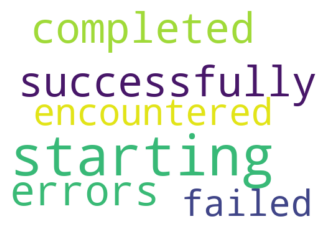

In [14]:
# get all log entries
text = " ".join(entry for entry in df.log)
plot_world_cloud(text)

In [15]:
# get bigram and plot the top 20
def get_top_n_bigram(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(2, 2), stop_words=stopwords, smooth_idf=False).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['log'], 20)
for word, freq in common_words:
    print("{0:35}{1:5.2f}".format(word,freq))

df1 = pd.DataFrame(common_words, columns = ['Log' , 'Count'])
df1.groupby('Log').sum()['Count'].sort_values(ascending=False).iplot( 
    kind='bar', yTitle='Count', linecolor='black', title='Top log entry')

completed successfully              5.00
errors encountered                  3.54
encountered failed                  3.54


In [16]:
# Function to calculate words frequency
def get_top_n_tf_words(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=stopwords, smooth_idf=False).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_tf_words(df['log'], 20)
for word, freq in common_words:
    print("{0:10}\t{1:5.2f}".format(word,freq))

df1 = pd.DataFrame(common_words, columns = ['Log' , 'Count'])
df1.groupby('Log').sum()['Count'].sort_values(ascending=False).iplot( 
    kind='bar', yTitle='Count', linecolor='black', title='Top log entry')

starting  	10.00
completed 	 3.54
successfully	 3.54
errors    	 2.89
encountered	 2.89
failed    	 2.89


In [72]:
# Plot read time as a time series
df.iplot(x='datetime',
    y='process', mode='markers',xTitle='Time', yTitle='Process Name', categories="process")

In [20]:
common_words[3:4]

[('errors', 2.8867513459481287)]

In [21]:
# get top 5 items from tuple list
top_3_seqs = [seq[0] for seq in common_words[3:4]]

In [22]:
df[df.log.str.contains('|'.join(top_3_seqs))].iplot(x='datetime',
    y='process', mode='markers',xTitle='Time', yTitle='Process Name', categories="process")

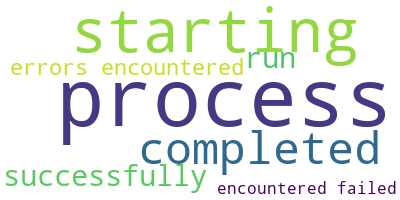

In [75]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['log'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [84]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['process','starting'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.log.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words)

[[], ['completed', 'successfully'], [], ['errors', 'encountered', 'failed', 'run'], [], ['completed', 'successfully'], [], ['errors', 'encountered', 'failed', 'run'], [], ['completed', 'successfully'], [], ['errors', 'encountered', 'failed', 'run'], [], ['completed', 'successfully'], [], ['errors', 'encountered', 'failed', 'run'], [], ['completed', 'successfully'], [], ['errors', 'encountered', 'failed', 'run']]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marissekar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus)

[[], [(0, 1), (1, 1)], [], [(2, 1), (3, 1), (4, 1), (5, 1)], [], [(0, 1), (1, 1)], [], [(2, 1), (3, 1), (4, 1), (5, 1)], [], [(0, 1), (1, 1)], [], [(2, 1), (3, 1), (4, 1), (5, 1)], [], [(0, 1), (1, 1)], [], [(2, 1), (3, 1), (4, 1), (5, 1)], [], [(0, 1), (1, 1)], [], [(2, 1), (3, 1), (4, 1), (5, 1)]]


<h2>Step 3: Perform Topic Modeling</h2>

In [86]:
from pprint import pprint
# number of topics
num_topics = 2
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.320*"successfully" + 0.316*"completed" + 0.098*"run" + '
  '0.091*"encountered" + 0.088*"failed" + 0.087*"errors"'),
 (1,
  '0.220*"errors" + 0.219*"failed" + 0.216*"encountered" + 0.212*"run" + '
  '0.068*"completed" + 0.065*"successfully"')]


In [87]:
# Import required libraries
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=           x    y  topics  cluster    Freq
topic                                     
1      0.071  0.0       1        1  65.086
0     -0.071  0.0       2        1  34.914, topic_info=           Term   Freq  Total Category  logprob  loglift
1  successfully  4.000  4.000  Default    6.000    6.000
0     completed  4.000  4.000  Default    5.000    5.000
3        errors  5.000  5.000  Default    4.000    4.000
4        failed  5.000  5.000  Default    3.000    3.000
2   encountered  5.000  5.000  Default    2.000    2.000
5           run  5.000  5.000  Default    1.000    1.000
3        errors  4.287  5.195   Topic1   -1.516    0.237
4        failed  4.271  5.192   Topic1   -1.520    0.234
2   encountered  4.226  5.184   Topic1   -1.530    0.225
5           run  4.145  5.168   Topic1   -1.550    0.209
0     completed  1.326  4.636   Topic1   -2.689   -0.822
1  successfully  1.270  4.625   Topic1   -2.733   -0.863
1  successfully  3.355  4.625   Topic2   -1.138    0.731
0     completed  3.309  4.636   Topic2   -1.152    0.715
5           run  1.023  5.168   Topic2   -2.326   -0.567
2   encountered  0.957  5.184   Topic2   -2.392   -0.637
4        failed  0.921  5.192   Topic2   -2.432   -0.677
3        errors  0.908  5.195   Topic2   -2.445   -0.692, token_table=      Topic   Freq          Term
term                            
0         1  0.216     completed
0         2  0.647     completed
2         1  0.772   encountered
2         2  0.193   encountered
3         1  0.770        errors
3         2  0.192        errors
4         1  0.770        failed
4         2  0.193        failed
5         1  0.774           run
5         2  0.193           run
1         1  0.216  successfully
1         2  0.649  successfully, R=6, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])